# Keystroke Dynamics

Some explanation here

## Keylogger

Some explanation here

In [1]:
# Imports
import keyboard # for keylogs
from threading import Timer
from datetime import datetime
import time
import sys

In [2]:
# Logging parameters
SEND_REPORT_EVERY = 10 # in seconds, 60 means 1 minute and so on
INTERRUPT_AFTER = 60 # in seconds, 60 means 1 minute and so on
start_time = time.time()

In [3]:
# Keylogger
class Keylogger:
    def __init__(self, interval, report_method="file"):
        # we gonna pass SEND_REPORT_EVERY to interval
        self.interval = interval
        self.report_method = report_method
        # this is the string variable that contains the log of all 
        # the keystrokes within `self.interval`
        self.log = ""
        # record start & end datetimes
        self.start_dt = datetime.now()
        self.end_dt = datetime.now()
        
        self.event_type = ""
        self.user = ""

    def callback(self, event):
        """
        This callback is invoked whenever a keyboard event is occured
        (i.e when a key is released in this example)
        """
        name = event.name
        ts = time.time()
        timestamp = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S %f')
        if len(name) > 1:
            # not a character, special key (e.g ctrl, alt, etc.)
            # uppercase with []
            if name == "space":
                # " " instead of "space"
                name = "[SPACE]"
            elif name == "enter":
                # add a new line whenever an ENTER is pressed
                name = "[ENTER]"
            elif name == "decimal":
                name = "."
            else:
                # replace spaces with underscores
                name = name.replace(" ", "_")
                name = f"[{name.upper()}]"
        # finally, add the key name to our global `self.log` variable
        self.log += "{} - {}\n".format(timestamp, name)
        # exit code if timer expired
        if time.time() - start_time > INTERRUPT_AFTER:
            sys.exit()

    def update_filename(self):
        # construct the filename to be identified by start & end datetimes
        start_dt_str = str(self.start_dt)[:-7].replace(" ", "-").replace(":", "")
        end_dt_str = str(self.end_dt)[:-7].replace(" ", "-").replace(":", "")
        self.filename = f"logs/{self.user}/{self.event_type}/keylog-{start_dt_str}_{end_dt_str}"

    def report_to_file(self):
        """This method creates a log file in the current directory that contains
        the current keylogs in the `self.log` variable"""
        # open the file in write mode (create it)
        with open(f"{self.filename}.txt", "w") as f:
            # write the keylogs to the file
            print(self.log, file=f)
        print(f"[+] Saved {self.filename}.txt")

    def report(self):
        """
        This function gets called every `self.interval`
        It basically sends keylogs and resets `self.log` variable
        """
        if self.log:
            # if there is something in log, report it
            self.end_dt = datetime.now()
            # update `self.filename`
            self.update_filename()
            if self.report_method == "file":
                self.report_to_file()
            # if you want to print in the console, uncomment below line
            # print(f"[{self.filename}] - {self.log}")
            self.start_dt = datetime.now()
        self.log = ""
        timer = Timer(interval=self.interval, function=self.report)
        # set the thread as daemon (dies when main thread die)
        timer.daemon = True
        # start the timer
        timer.start()

    def start(self, user, event):
        # record the start datetime
        self.start_dt = datetime.now()
        self.event_type = event
        self.user = user
        # start the keylogger
        if event == 'press':
            keyboard.on_press(callback=self.callback)
        if event == 'release':
            keyboard.on_release(callback=self.callback)
        # start reporting the keylogs
        self.report()
        # block the current thread, wait until CTRL+C is pressed
        keyboard.wait()

In [4]:
# Calling the keylogger
# user = "intruder"
# keylogger = Keylogger(interval=SEND_REPORT_EVERY, report_method="file")
# keylogger.start(user, "press")
# keylogger.start(user, "release")

## Preprocessing the logs for known users

Some explanation here

In [90]:
# Imports
import glob
import pandas as pd
import sys
import math

from datetime import datetime

In [91]:
def preprocess(user=None):
    press_files = glob.glob(f"logs/{user}/press/*.txt")
    press_rows = []

    release_files = glob.glob(f"Logs/{user}/release/*.txt")
    release_rows = []

    for press_file in press_files:
        with open(press_file) as fp:
            line = fp.readline()
            while line:
                if line == "\n":
                    line = fp.readline()
                    continue
                timestamp = datetime.strptime(
                    line.strip().split(" - ")[0], '%Y-%m-%d %H:%M:%S %f')
                key = line.strip().split(" - ")[1].lower()
                press_rows.append({
                    "timestamp": timestamp,
                    "key": key
                })
                line = fp.readline()

    for release_file in release_files:
        with open(release_file) as fp:
            line = fp.readline()
            while line:
                if line == "\n":
                    line = fp.readline()
                    continue
                timestamp = datetime.strptime(
                    line.strip().split(" - ")[0], '%Y-%m-%d %H:%M:%S %f')
                key = line.strip().split(" - ")[1].lower()
                release_rows.append({
                    "timestamp": timestamp,
                    "key": key
                })
                line = fp.readline()

    press_df = pd.DataFrame(press_rows)
    release_df = pd.DataFrame(release_rows)

    # Map release -> press and build dataset
    dataset_rows = []
    for _, row in release_df.drop_duplicates(subset=['key']).iterrows():
        sub_df = release_df[release_df["key"] == row['key']]
        lower_bound = None
        for sub_id, sub_row in sub_df.reset_index().iterrows():
            higher_bound = sub_row["timestamp"]
            if sub_id == 0:
                press_time = press_df[(press_df["key"] == sub_row["key"]) & (
                    press_df["timestamp"] < higher_bound)].iloc[0]["timestamp"]
            else:
                press_time = press_df[(press_df["key"] == sub_row["key"]) & (
                    press_df["timestamp"] < higher_bound) & (press_df["timestamp"] > lower_bound)].iloc[0]["timestamp"]
            lower_bound = higher_bound
            dataset_rows.append({
                "key": sub_row["key"],
                "pressed": press_time,
                "released": sub_row["timestamp"],
                "user": user
            })

    dataset = pd.DataFrame(dataset_rows).sort_values(['pressed'])

    dataset["hold_time"] = (dataset["released"] -
                            dataset["pressed"]) / pd.Timedelta(microseconds=1)
    press_press_time = []
    press_release_time = []
    release_release_time = []

    for index, row in dataset.reset_index().iterrows():
        press_press_delta = (dataset.iloc[index+1]["pressed"] -
                             dataset.iloc[index]["pressed"]) / pd.Timedelta(microseconds=1)
        press_press_time.append(press_press_delta)
        release_release_delta = (
            dataset.iloc[index+1]["released"] - dataset.iloc[index]["released"]) / pd.Timedelta(microseconds=1)
        release_release_time.append(release_release_delta)
        press_release_delta = (
            dataset.iloc[index+1]["pressed"] - dataset.iloc[index]["released"]) / pd.Timedelta(microseconds=1)
        press_release_time.append(press_release_delta)

        if index == len(dataset) - 2:
            press_press_time.append(0)
            press_release_time.append(0)
            release_release_time.append(0)
            break

    dataset["press_press_time"] = press_press_time
    dataset["press_release_time"] = press_release_time
    dataset["release_release_time"] = release_release_time

    dataset.to_csv(f"datasets/{user}_data.csv", index=False)

    return dataset

In [92]:
registered_users = ["alex", "stefan", "zihao", "zineb"]
# for user in users, create a preprocess, for now only 1
dataframe = preprocess("alex")

## Statistical Analysis

In [93]:
# Imports
import pandas as pd
import glob
import json

In [94]:
# Statistical analysis
def compute_statistics(dataset):
    average_hold_time = dataset["hold_time"].mean()
    average_press_press_time = dataset.iloc[:len(
        dataset)-1]["press_press_time"].mean()
    average_press_release_time = dataset.iloc[:len(
        dataset)-1]["press_release_time"].mean()
    average_release_release_time = dataset.iloc[:len(
        dataset)-1]["release_release_time"].mean()
    apm = len(dataset) * 60 * math.pow(10, 6) / ((dataset.iloc[len(
        dataset)-1]["pressed"] - dataset.iloc[0]["pressed"]) / pd.Timedelta(microseconds=1))
    error_rate = len(
        dataset[dataset["key"] == "[backspace]"]) * 100 / len(dataset)
    ret = {
            "average_hold_time": average_hold_time,
            "average_press_press_time": average_press_press_time,
            "average_press_release_time": average_press_release_time,
            "average_release_release_time": average_release_release_time,
            "apm": apm,
            "error_rate": error_rate
        }
    return ret

In [95]:
# storing the statistics
files = glob.glob("datasets/*.csv")
rows = []
dataframe = pd.DataFrame()
for file in files:
    dataset = pd.read_csv(file, parse_dates=['pressed', 'released'])
    dataframe = dataframe.append(dataset)
    # Analyse statistique
    stats = compute_statistics(dataset)
    stats["user"] = dataset.iloc[0]["user"]
    rows.append(stats)
statistics = pd.DataFrame(rows)

### Statistics visualisation

In [96]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import math

In [97]:
statistics

average_hold_time  average_press_press_time  average_press_release_time  \
0      274643.275064             196883.110825               -78105.520619   
1      107527.354545             192648.159817                85190.452055   
2      135697.088305             247128.114695               111377.781362   
3       76886.756809             130400.771930                53523.996101   

   average_release_release_time         apm  error_rate    user  
0                 170660.778351  305.534786    3.856041    alex  
1                 192805.639269  312.870741    6.363636  stefan  
2                 247077.870968  243.079120    3.818616   zihao  
3                 130080.136452  461.016896    3.307393   zineb

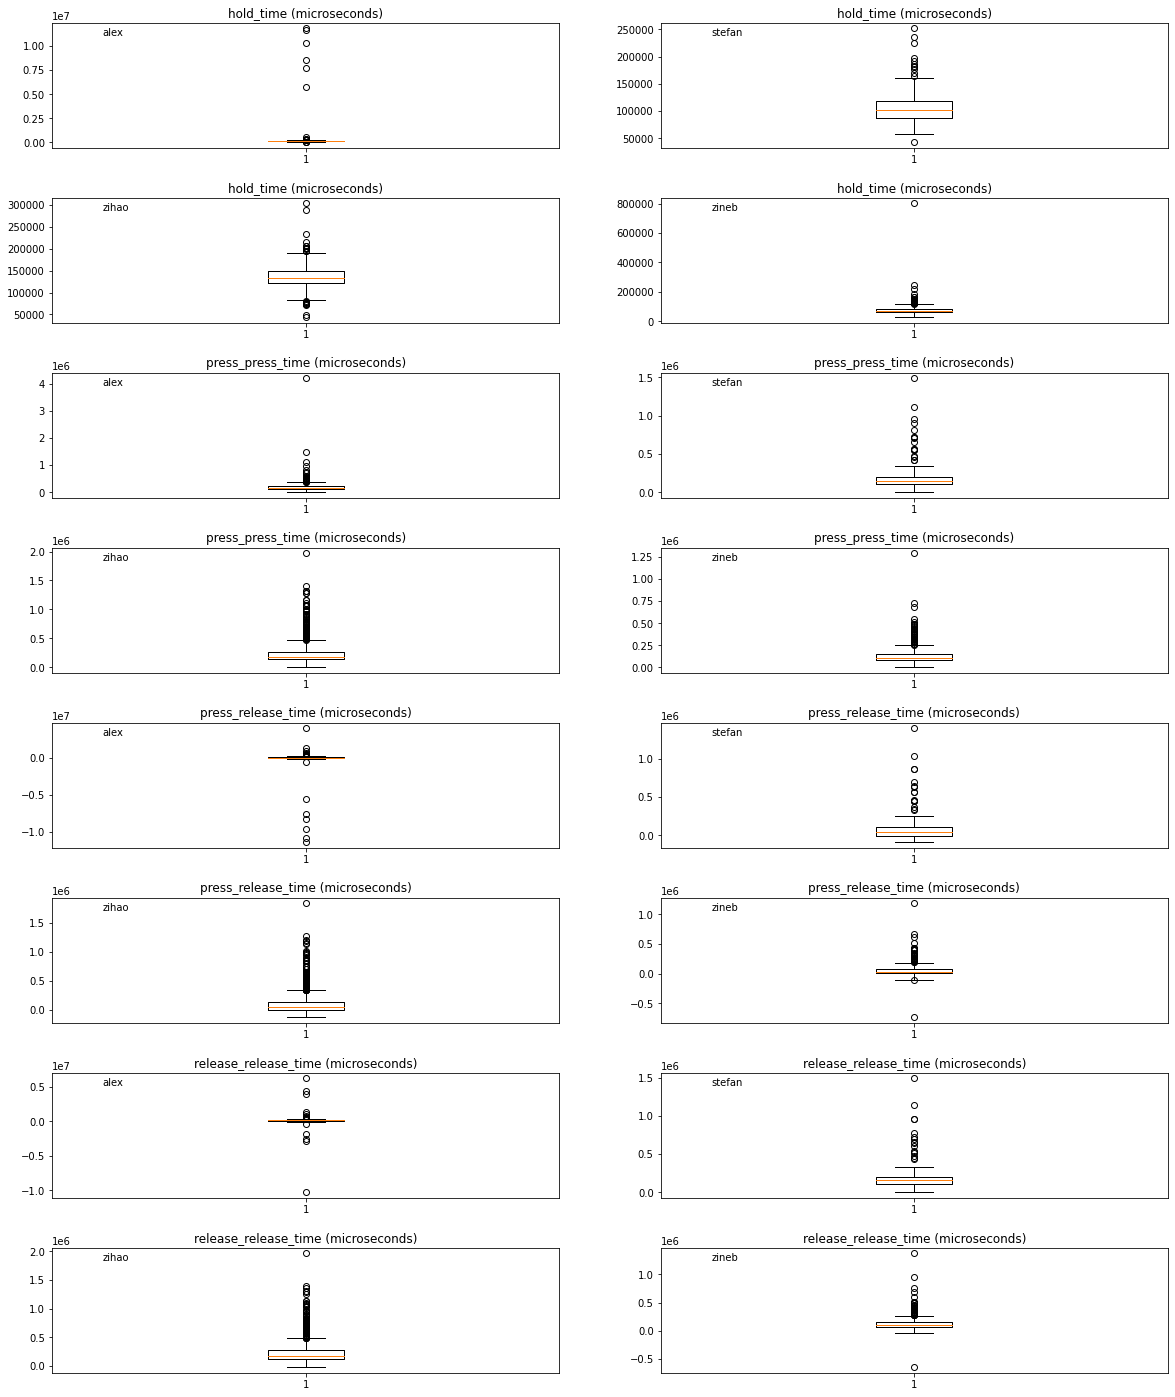

In [98]:
features = ['hold_time', 'press_press_time', 'press_release_time', 'release_release_time']
fig, axs = plt.subplots(8, 2, figsize=(20, 10))
fig.subplots_adjust(top=2, hspace=0.4)
n=0
for feature in features:
    for user in registered_users:
        axs[int(n/2), int(n%2)].text(.1,.9,user, horizontalalignment='left',transform=axs[int(n/2), int(n%2)].transAxes)
        axs[int(n/2), int(n%2)].boxplot(dataframe[dataframe['user']==user][feature])
        axs[int(n/2), int(n%2)].set_title(f"{feature} (microseconds)")
        n+=1
        

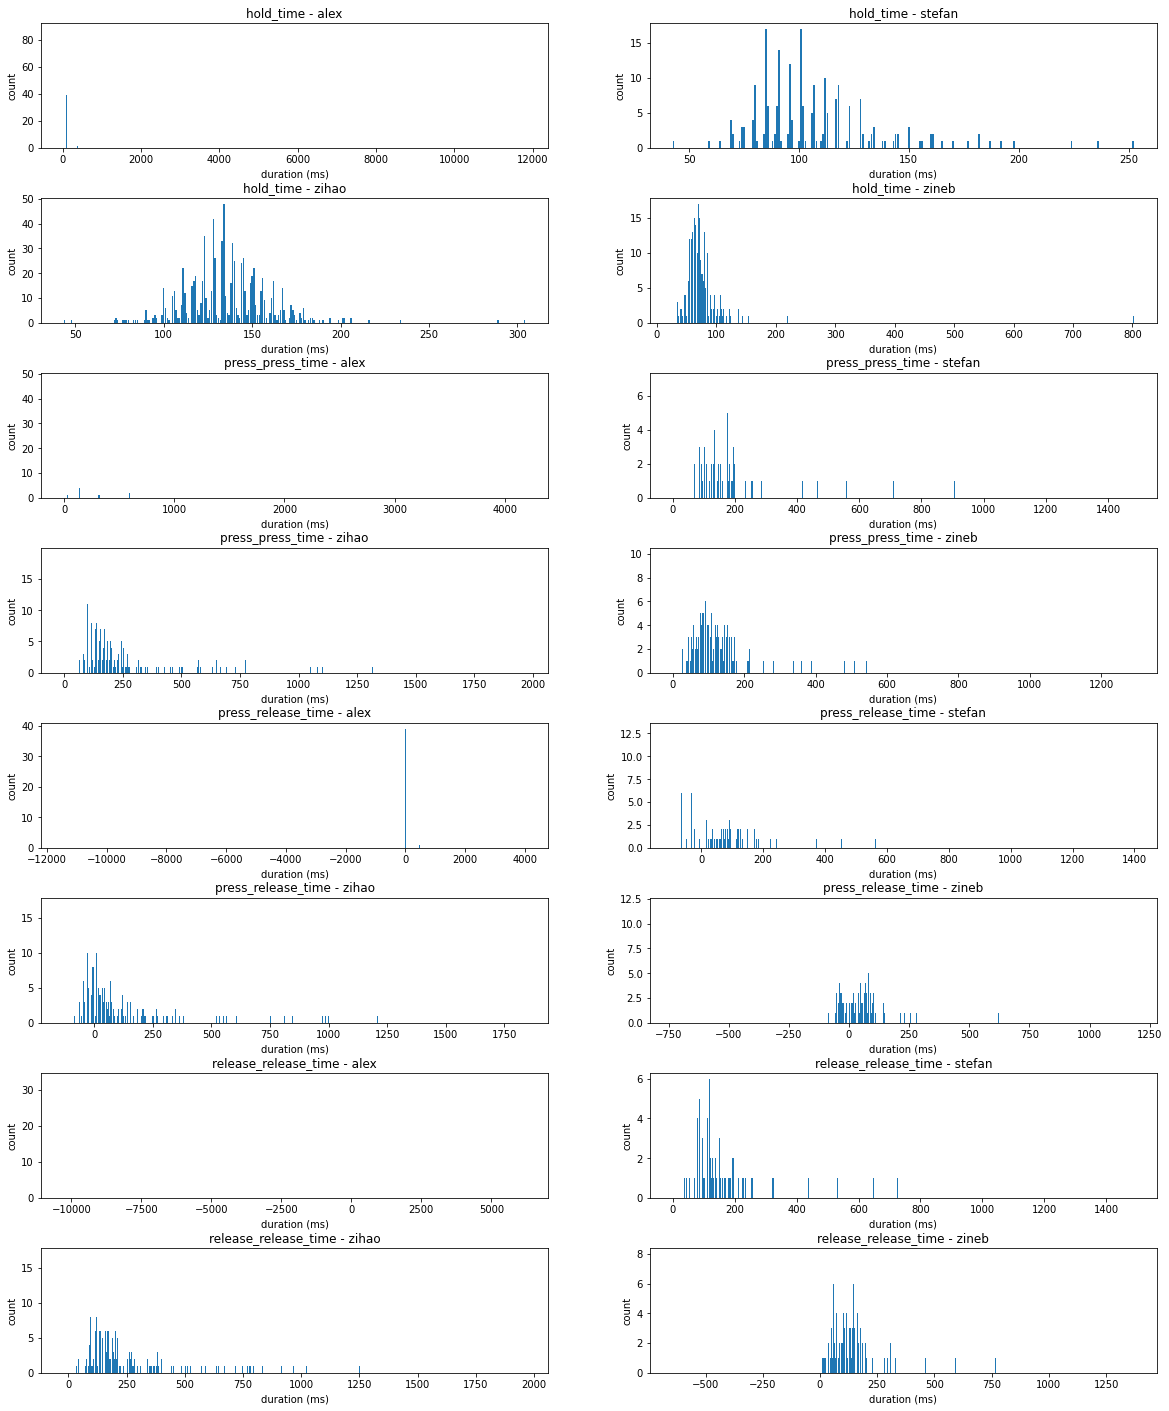

In [99]:
merged = dataframe.copy()

# Rounding to closest milisecond
for feature in features:
    merged[feature] = merged[feature].apply(lambda x: round(x/1000))
fig, axs = plt.subplots(8, 2, figsize=(20, 10))
fig.subplots_adjust(top=2, hspace=0.4)
n=0
for feature in features:
    for user in registered_users:
        mm = pd.DataFrame(merged[merged['user']==user].groupby(feature)[feature].count()).rename(columns={feature:'count'}).reset_index()
        axs[int(n/2), int(n%2)].bar(mm[feature], mm['count'])
        axs[int(n/2), int(n%2)].set_ylabel('count')
        axs[int(n/2), int(n%2)].set_xlabel('duration (ms)')
        axs[int(n/2), int(n%2)].set_title(f"{feature} - {user}")
        n+=1

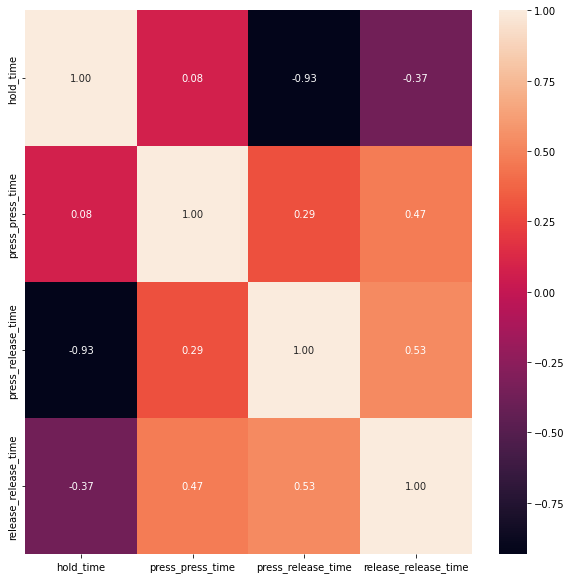

In [100]:
# Correlation
rcParams['figure.figsize'] = 10, 10
fig = plt.figure()
sns.heatmap(dataframe.corr(), annot=True, fmt=".2f")
plt.show()

In [101]:
dataframe

key                    pressed                   released   user  \
0    [backspace] 2021-10-20 10:11:55.546261 2021-10-20 10:12:05.861171   alex   
1              r 2021-10-20 10:11:56.249979 2021-10-20 10:12:03.999973   alex   
2              e 2021-10-20 10:11:56.339664 2021-10-20 10:12:08.024484   alex   
3              l 2021-10-20 10:11:56.595771 2021-10-20 10:12:05.158075   alex   
4              a 2021-10-20 10:11:56.806948 2021-10-20 10:12:02.531455   alex   
..           ...                        ...                        ...    ...   
509  [backspace] 2021-10-20 11:11:11.699393 2021-10-20 11:11:11.742341  zineb   
510  [backspace] 2021-10-20 11:11:11.805348 2021-10-20 11:11:11.879339  zineb   
511            h 2021-10-20 11:11:11.958236 2021-10-20 11:11:12.052549  zineb   
512            e 2021-10-20 11:11:12.021588 2021-10-20 11:11:12.092408  zineb   
513            m 2021-10-20 11:11:12.152168 2021-10-20 11:11:12.234175  zineb   

      hold_time  press_press_time  press_release_time  release_release_time  
0    10314910.0          703718.0          -9611192.0            -1861198.0  
1     7749994.0           89685.0          -7660309.0             4024511.0  
2    11684820.0          256107.0         -11428713.0            -2866409.0  
3     8562304.0          211177.0          -8351127.0            -2626620.0  
4     5724507.0          129300.0          -5595207.0             6211471.0  
..          ...               ...                 ...                   ...  
509     42948.0          105955.0             63007.0              136998.0  
510     73991.0          152888.0             78897.0              173210.0  
511     94313.0           63352.0            -30961.0               39859.0  
512     70820.0          130580.0             59760.0              141767.0  
513     82007.0               0.0                 0.0                   0.0  

[1961 rows x 8 columns]

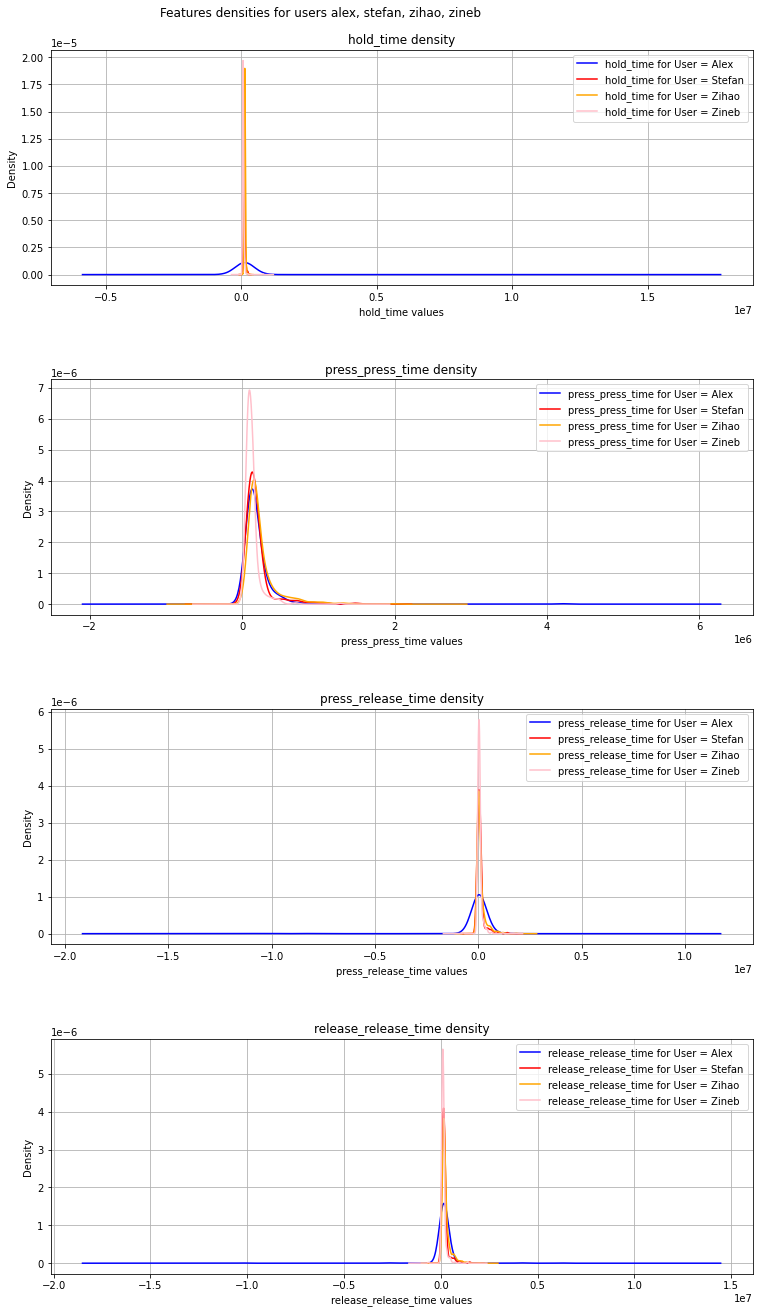

In [102]:
rcParams['figure.figsize'] = 15, 20

# separate data based on users
outcome_alex = dataframe[dataframe['user']=='alex'][features]
outcome_stefan = dataframe[dataframe['user']=='stefan'][features]
outcome_zihao = dataframe[dataframe['user']=='zihao'][features]
outcome_zineb = dataframe[dataframe['user']=='zineb'][features]

# init figure
fig, axs = plt.subplots(4, 1)
fig.suptitle('Features densities for users alex, stefan, zihao, zineb')
plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                    wspace = 0.2, hspace = 0.4)

colors = ['blue', 'red', 'orange', 'pink']
# plot densities for outcomes
i = 0
for feature in features: 
    ax = axs[i]
    outcome_alex[feature].plot(kind='density', ax=ax, subplots=True, 
                                sharex=False, color=colors[0], legend=True,
                                label=feature + ' for User = Alex')
    outcome_stefan[feature].plot(kind='density', ax=ax, subplots=True, 
                                sharex=False, color=colors[1], legend=True,
                                label=feature + ' for User = Stefan')
    outcome_zihao[feature].plot(kind='density', ax=ax, subplots=True, 
                                sharex=False, color=colors[2], legend=True,
                                label=feature + ' for User = Zihao')
    outcome_zineb[feature].plot(kind='density', ax=ax, subplots=True, 
                                sharex=False, color=colors[3], legend=True,
                                label=feature + ' for User = Zineb')
    ax.set_xlabel(feature + ' values')
    ax.set_title(feature + ' density')
    ax.grid('on')
    i+=1
plt.show()

## Models


Some explanation here

In [103]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import glob
import math
import pickle
import json
import numpy as np

### KNN

#### Model

In [104]:
X = dataframe[dataframe.columns.difference(
        ['user', 'pressed', 'released', 'key'])]

lb_make = LabelEncoder()
dataframe['user_code'] = lb_make.fit_transform(dataframe["user"])

print(dataframe[['user', 'user_code']].drop_duplicates())

dataframe = dataframe.drop(columns=['user'])

y = dataframe['user_code'].values
#y = dataframe["user"].values
# print(y[0:5])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scalerPickle = open('models/scalerpickle_file', 'wb')
pickle.dump(scaler, scalerPickle)

# Instantiate the model with 4 neighbors.
knn = KNeighborsClassifier(n_neighbors=4)
# Fit the model on the training data.
knn.fit(X_train, y_train)
# print(knn.predict(X_test)[0:5])
# See how the model performs on the test data.

knnPickle = open('models/knnpickle_file', 'wb')
pickle.dump(knn, knnPickle)

print(knn.score(X_test, y_test))

     user  user_code
0    alex          0
0  stefan          1
0   zihao          2
0   zineb          3
0.6456211812627292


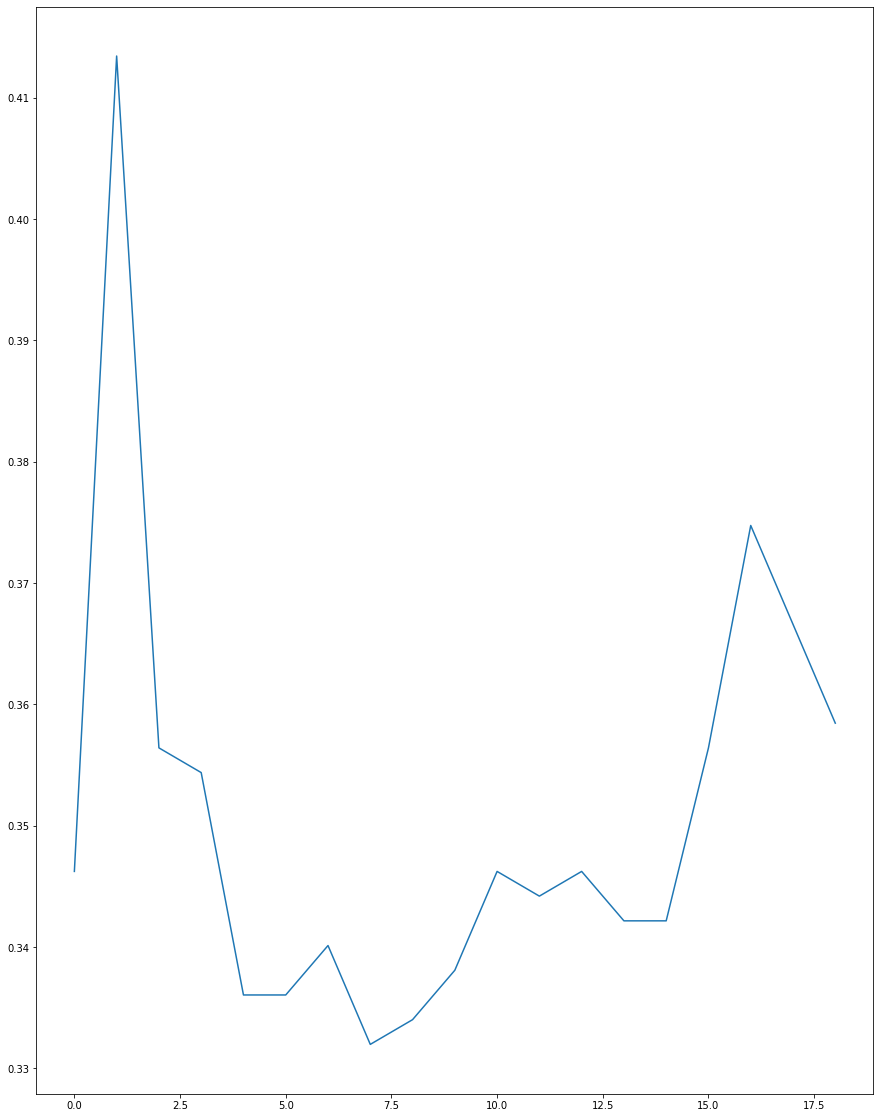

In [105]:
# Determine k
error_rates = []
for i in np.arange(1, 20):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(X_train, y_train)
    new_predictions = new_model.predict(X_test)
    error_rates.append(np.mean(new_predictions != y_test))
    
plt.plot(error_rates)

#### Visualisation

In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [107]:
predictions = knn.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.45      0.43      0.44       101
           1       0.43      0.34      0.38        67
           2       0.69      0.79      0.74       196
           3       0.82      0.76      0.79       127

    accuracy                           0.65       491
   macro avg       0.60      0.58      0.59       491
weighted avg       0.64      0.65      0.64       491



In [108]:
print(confusion_matrix(y_test, predictions))

[[ 43   7  45   6]
 [ 14  23  16  14]
 [ 35   5 154   2]
 [  4  19   7  97]]


C:\Users\Zineb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Zineb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Users\Zineb\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


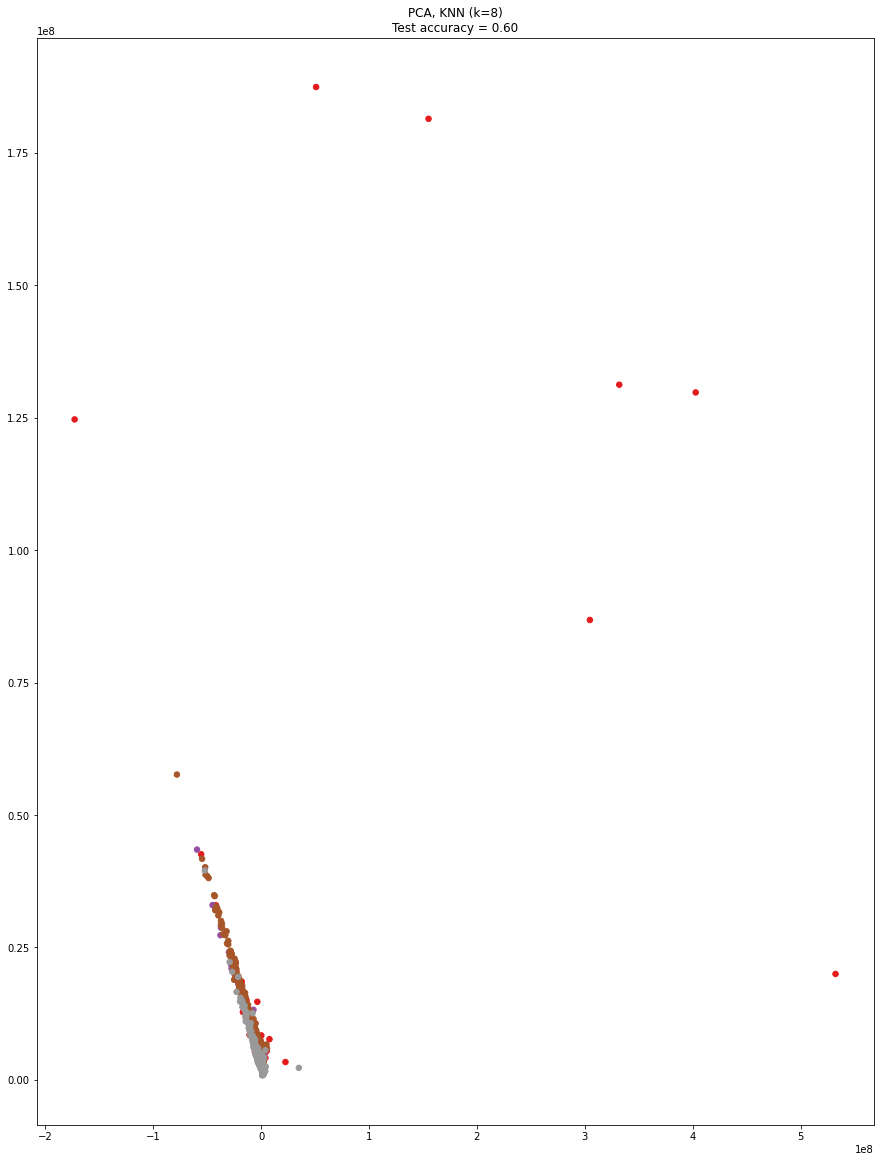

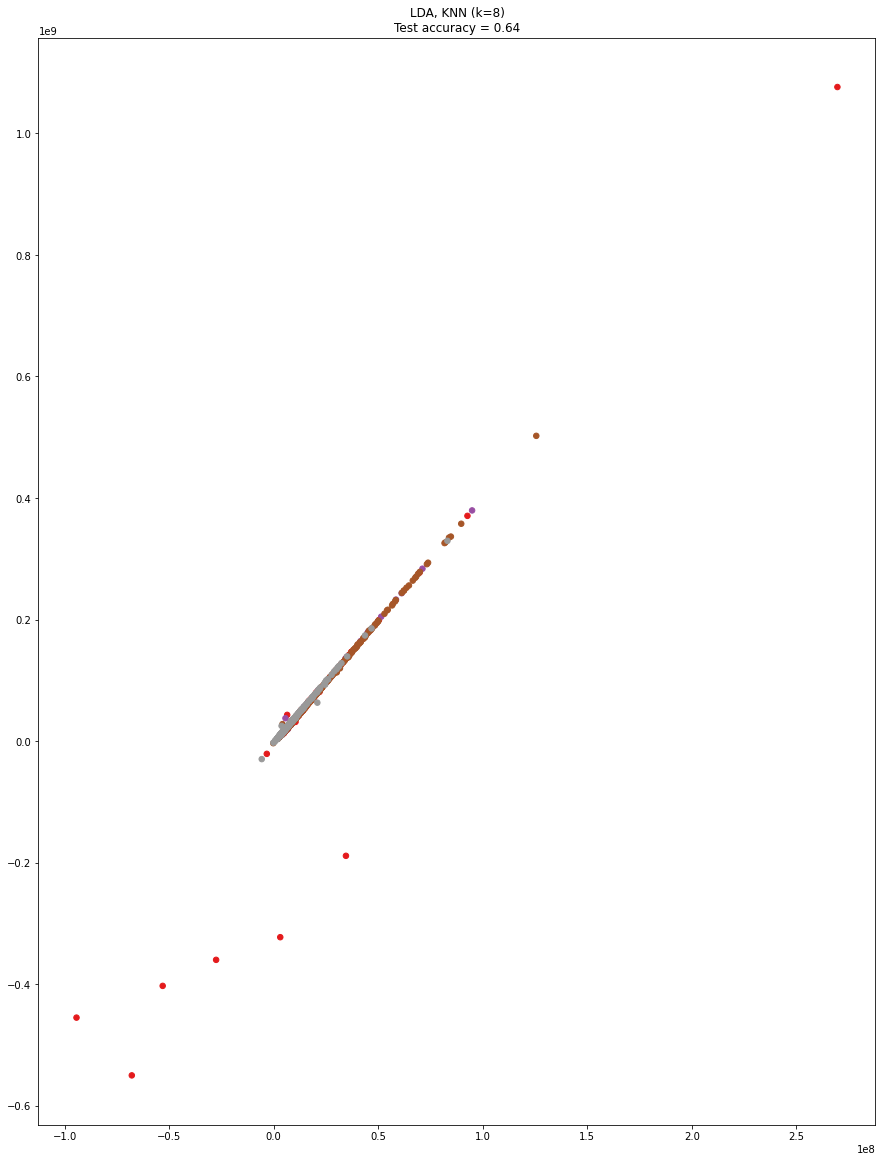

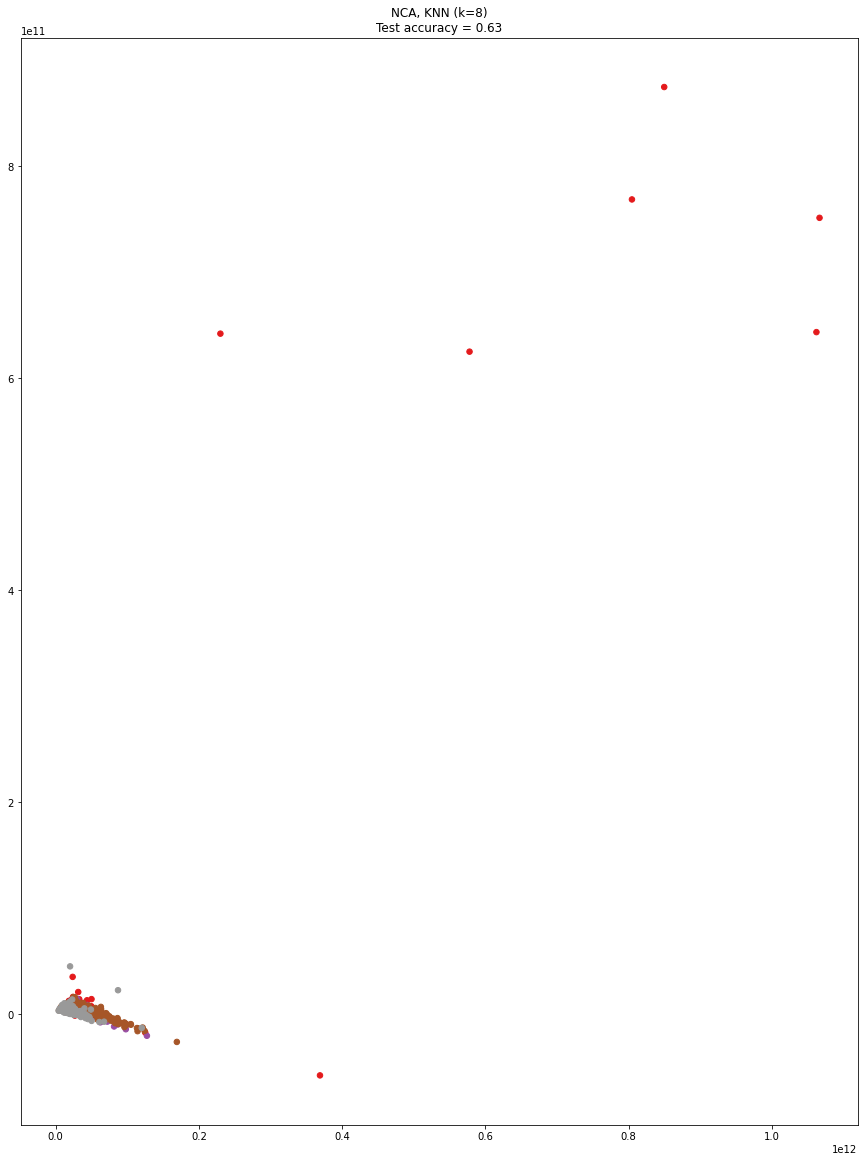

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

dim = X.shape[0]
n_classes = len(np.unique(y))

n_neighbors = 8
random_state = 0

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=random_state))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=2, random_state=random_state),
)

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# Make a list of the methods to be compared
dim_reduction_methods = [("PCA", pca), ("LDA", lda), ("NCA", nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(X)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(
        "{}, KNN (k={})\nTest accuracy = {:.2f}".format(name, n_neighbors, acc_knn)
    )
plt.show()

## Gradient Boosting

In [110]:
gb = GradientBoostingClassifier(
        n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
print(gb.score(X_test, y_test))
gbPickle = open('models/gbpickle_file', 'wb')
pickle.dump(gb, gbPickle)

0.8309572301425662


# Recognition

## KNN

In [111]:
# Load model
loaded_knn = pickle.load(open('models/knnpickle_file', 'rb'))
loaded_gb = pickle.load(open('models/gbpickle_file', 'rb'))
loaded_scaler = pickle.load(open('models/scalerpickle_file', 'rb'))

# Load file
dataframe = preprocess("zineb")
X = dataframe[dataframe.columns.difference(
    ['user', 'pressed', 'released', 'key'])]

knn_result = loaded_knn.predict(loaded_scaler.transform(X))
certainty = max(np.bincount(knn_result)) * 100 / sum(np.bincount(knn_result))
print(certainty)

85.7976653696498


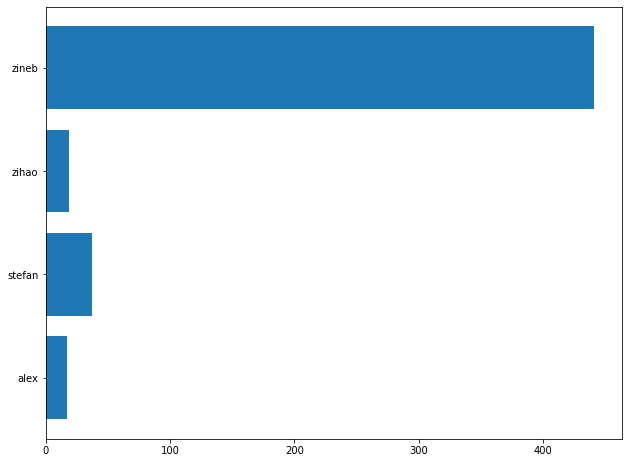

In [112]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0, 0, 1, 1])
ax.barh(registered_users, list(np.bincount(knn_result)))
plt.show()

## Gradient Boosting

In [113]:
gb_result = loaded_gb.predict(loaded_scaler.transform(X))
certainty = max(np.bincount(gb_result)) * 100 / sum(np.bincount(gb_result))
print(certainty)

93.77431906614785


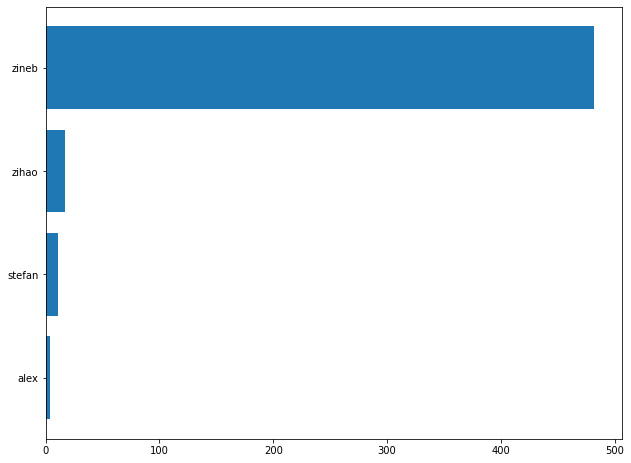

In [114]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0,0,1,1])
ax.barh(registered_users, list(np.bincount(gb_result)))
plt.show()